### 4-9. 프로젝트: Vocabulary Size를 변경해서 시도해보기

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.

앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요.

라이브러리 버전을 확인해 봅니다.  
사용할 라이브러리 버전을 둘러봅시다.

In [1]:

from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1. 모든 단어 사용

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


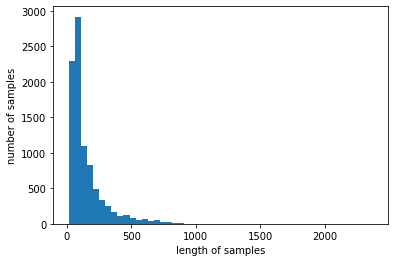

In [3]:
# 데이터 분포 
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


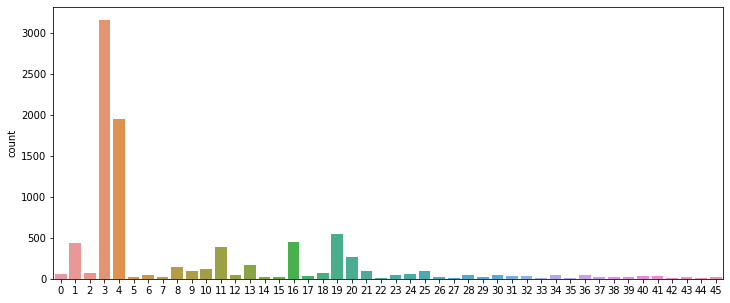

In [4]:
# 타겟데이터
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)


In [5]:
# 텍스트데이터로 복원
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

565248/550378 [==============================] - 0s 0us/step


In [6]:
# 전체 학습데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [7]:
# 전체 테스트데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [8]:
# DTM 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 테스트데이터
x_test_dtm = dtmvector.transform(x_test) 

(8982, 26506)


In [9]:
# TF-IDF Matrix확인
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

# 테스트데이터
tfidfv_test = tfidf_transformer.transform(x_test_dtm) 

(8982, 26506)


### ※ 모델별 정확도 계산

In [10]:
# 결과값 비교를 위한 리스트 선언
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "GradientBoostingClassifier", "Voting"]
classifier_answer_list = []

In [11]:
# 1. 나이브 베이즈 분류기

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

predicted = mod.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 

정확도: 0.5997328584149599


In [12]:
# 2. Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7649154051647373


In [13]:
# 3. 로지스틱 회귀

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.813446126447017


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [14]:
# 4. SVM

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.786286731967943


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [15]:
# 5.Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6211041852181657


In [16]:
# 6. Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6544968833481746


In [17]:
# 7. GBM

grbt = GradientBoostingClassifier(random_state=0) 
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7702582368655387


In [18]:
# 8. Voting 

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8187889581478184


In [19]:
# 전체 정리

print("빈도수 제한없을 때 정확도 리스트")
print()
for x in range(len(classifier_list)):
    print(classifier_list[x], ":", classifier_answer_list[x].round(2))

빈도수 제한없을 때 정확도 리스트

MultinomialNB : 0.76
ComplementNB : 0.81
Logistic Regression : 0.79
LinearSVC : 0.62
Decision Tree : 0.65
Random Forest : 0.77
GradientBoostingClassifier : 0.82


IndexError: ignored

### 2. 빈도수 상위 5,000개의 단어만 사용

In [20]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


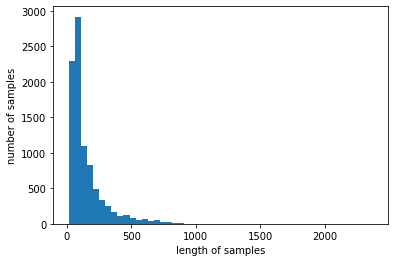

In [21]:
# 데이터 분포
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


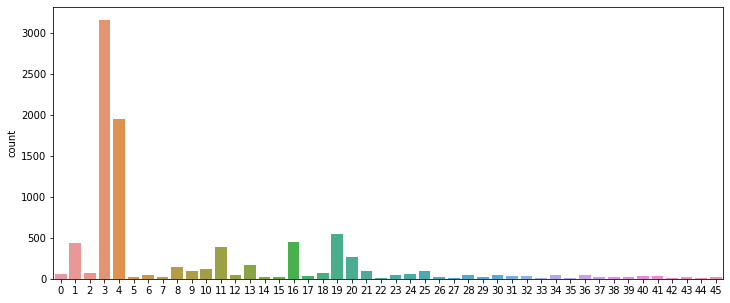

In [22]:
# 타겟데이터 파악
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [23]:
# 텍스트데이터로 복원
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [24]:
# 전체 학습데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [25]:
# 전체 테스트데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [26]:
# DTM 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 테스트데이터
x_test_dtm = dtmvector.transform(x_test) 

(8982, 4867)


In [27]:
# TF-IDF Matrix확인
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

# 테스트데이터
tfidfv_test = tfidf_transformer.transform(x_test_dtm) 

(8982, 4867)


In [28]:
# 결과값 비교를 위한 리스트 선언
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "GradientBoostingClassifier", "Voting"]
classifier_answer_list = []

In [29]:
# 1. 나이브 베이즈

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

predicted = mod.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6731967943009796


In [30]:
# 2. CNB

cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


In [31]:
# 3. 로지스틱 회귀

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8058771148708815


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [32]:
# 4. SVM

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.763579697239537


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [33]:
# 5. Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6179875333926982


In [34]:
# 6. Randcom Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.701246660730187


In [35]:
# 7. GBM

grbt = GradientBoostingClassifier(random_state=0) 
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) 
print("정확도:", accuracy_score(y_test, predicted)) 
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.767586821015138


In [36]:
# 8. Voting 

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8161175422974176


In [37]:
# 전체 정리

print("빈도수 상위 5,000개의 단어만 사용했을 때 정확도 리스트")

for x in range(len(classifier_list)):
    print(classifier_list[x], ":", classifier_answer_list[x].round(2))

빈도수 상위 5,000개의 단어만 사용했을 때 정확도 리스트
MultinomialNB : 0.67
ComplementNB : 0.77
Logistic Regression : 0.81
LinearSVC : 0.76
Decision Tree : 0.62
Random Forest : 0.7
GradientBoostingClassifier : 0.77
Voting : 0.82


### 3. 직접 단어 개수를 설정해서 사용
위 단계에서 5000으로 제시된 num_words를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요.  
최소 3가지 경우 이상을 실험해 보기를 권합니다.

In [38]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=8000, test_split=0.2)

In [39]:

# 텍스트데이터로 복원
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [40]:
# 전체 학습데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [41]:
# 전체 테스트데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [42]:
# DTM 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 테스트데이터
x_test_dtm = dtmvector.transform(x_test)  

(8982, 7772)


In [43]:
# TF-IDF Matrix확인
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

# 테스트데이터
tfidfv_test = tfidf_transformer.transform(x_test_dtm)  

(8982, 7772)


In [44]:
# 결과값 비교를 위한 리스트 선언
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "GradientBoostingClassifier", "Voting"]
classifier_answer_list = []

In [45]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

predicted = mod.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6625111308993766


In [46]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


In [47]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8098842386464826


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [48]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7796081923419412


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [49]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6206589492430988


In [50]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6669634906500446


In [51]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7644701691896705


In [52]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test)  
print("정확도:", accuracy_score(y_test, predicted))  
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.813446126447017


In [53]:
# 전체 정리

print("빈도수 상위 8,500개의 단어만 사용했을 때 정확도 리스트")

for x in range(len(classifier_list)):
    print(classifier_list[x], ":", classifier_answer_list[x].round(2))

빈도수 상위 8,500개의 단어만 사용했을 때 정확도 리스트
MultinomialNB : 0.66
ComplementNB : 0.77
Logistic Regression : 0.81
LinearSVC : 0.78
Decision Tree : 0.62
Random Forest : 0.67
GradientBoostingClassifier : 0.76
Voting : 0.81


### 4. 딥러닝 모델과 비교해 보기
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정 분석 등에 사용했던  
 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다.   
 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

In [54]:
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt

In [55]:
# 데이터 로드
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [56]:
print(train_data.shape, train_labels.shape)

(8982,) (8982,)


In [57]:
print(test_data.shape, test_labels.shape)

(2246,) (2246,)


In [58]:

from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [59]:
# 원핫인코딩을 해줍시다
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [60]:
from keras import models
from keras import layers

# 모델 생성
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(124, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 클래스가 46개

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 124)               31868     
                                                                 
 dense_2 (Dense)             (None, 64)                8000      
                                                                 
 dense_3 (Dense)             (None, 46)                2990      
                                                                 
Total params: 2,603,114
Trainable params: 2,603,114
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 모델 컴파일 설정
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
# 데이터 나누기
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [64]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 122ms/step - loss: 2.8148 - accuracy: 0.4912 - val_loss: 1.7766 - val_accuracy: 0.6070
Epoch 2/20
16/16 [==============================] - 2s 106ms/step - loss: 1.4405 - accuracy: 0.6789 - val_loss: 1.2924 - val_accuracy: 0.7080
Epoch 3/20
16/16 [==============================] - 2s 106ms/step - loss: 0.9891 - accuracy: 0.7757 - val_loss: 1.0776 - val_accuracy: 0.7620
Epoch 4/20
16/16 [==============================] - 2s 106ms/step - loss: 0.6757 - accuracy: 0.8467 - val_loss: 0.9660 - val_accuracy: 0.8040
Epoch 5/20
16/16 [==============================] - 2s 106ms/step - loss: 0.4354 - accuracy: 0.9028 - val_loss: 0.9310 - val_accuracy: 0.8070
Epoch 6/20
16/16 [==============================] - 2s 105ms/step - loss: 0.2853 - accuracy: 0.9352 - val_loss: 0.9561 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 2s 106ms/step - loss: 0.2015 - accuracy: 0.9486 - val_loss: 1.0000 - val_accuracy: 0.8030
Epoch 

In [65]:
# 모델 평가
model.evaluate(x_test, one_hot_test_labels)

71/71 [==============================] - 0s 6ms/step - loss: 1.2467 - accuracy: 0.7912


[1.2466752529144287, 0.7911843061447144]

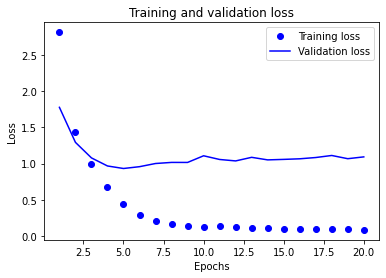

In [66]:
# 시각화
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### [회고]

여러 가지 분류기를 한번에 돌리고 평가하는 함수를 짤 수 있으면 좋겠다. 이렇게 7가지 모델을 가각 입력하는 것은 아닌 것 같다. 

GBM과 Voting은 확실히 시간이 많이 걸린다. 

NN은 층을 4개 밖에 쌓지 않았고 파마리터도 튜닝하지 않았는데 그런대로 잘 돌아간다. 